## Bidirectional LSTM + Character-level-embedding + CRF

### Running on the 3627 files to prepare the training dataset

https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/

Enhancing sequence tagging: Bidirectional LSTMs With Character Embeddings For Named Entity Recognition

In [8]:
import glob, os, csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# OzROC 12,000 sentences
filename = r"C:\Users\20230326\1-2 OzROCK\annotation_3627files.txt" # 160,344 sentences

#filename = r"C:\Users\20230326\wamex\data\OzROCK_Labeled_Geological_Dataset.txt"  # 480 files
data = pd.read_csv(filename, header = None, delimiter=" ", na_values=['\n'], quoting=csv.QUOTE_NONE, encoding='latin1', skip_blank_lines=True)
print(data.info())
print(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4490751 entries, 0 to 4490750
Data columns (total 2 columns):
0    object
1    object
dtypes: object(2)
memory usage: 68.5+ MB
None
           0          1
0        box          O
1      11799          O
2       ruby  B-MINERAL
3       well          O
4          e          O
5         51          O
6        959          O
7    partial          O
8  surrender          O
9     report          O


In [9]:
#data = dataframes.where((pd.notnull(dataframes)), None)
#data = data.fillna('')
data = data.replace(np.nan, '', regex=True)

words = list(set(data[0].values))
words.append("ENDPAD")
n_words = len(words) # unique words per file
print("Number of unique words in this file: ", n_words)

tags = list(set(data[1].values))
n_tags = len(tags)
print("Number of unique tags in this file: ", n_tags)
print(tags)
#data.info()
#print(data.head(10))

print(len(words))
print(words[:10])

Number of unique words in this file:  66737
Number of unique tags in this file:  13
['B-TIMESCALE', 'I-STRAT', 'I-LOCATION', 'I-ORE_DEPOSIT', 'B-STRAT', 'B-ORE_DEPOSIT', 'I-TIMESCALE', 'B-LOCATION', 'B-MINERAL', 'I-MINERAL', 'I-ROCK', 'B-ROCK', 'O']
66737
['', 'roadhurst', 'gd013', 'slight', 'fans', '120mesh', 'i.,2003', 'uplifted', '579ppm', '0.00069']


In [10]:
sentences = []
with open(filename, 'r') as file :
    currSentence = []
    lines = []
    for line in file:
        cols = line.split(" ")
        if len(cols) == 1:
            # Reset sentence            
            sentences.append(currSentence)
            currSentence = []
        else :
            currSentence.append([cols[0].strip(), cols[1].strip()])
print(len(sentences)) # 18589; 160,343

160343


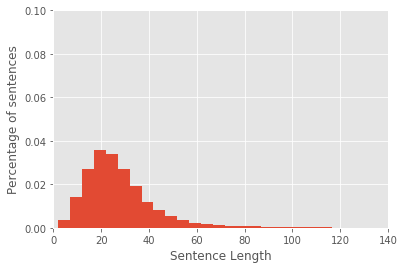

In [11]:
sent_lengths = [len(s) for s in sentences]

plt.hist(sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()
# dictionaries of words and tags.#print(sent_lengths)
# 

To encode the character-level information, we will use character embeddings and a LSTM to encode every word to an vector.
We can use basically everything that produces a single vector for a sequence of characters that represent a word. You can also use a max-pooling architecture or a CNN or whatever works.
Then we feed the vector to another LSTM together with the learned word embedding.

In [21]:
# Create dictionaries of words and tags.
word2idx = {w: i + 4 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
word2idx["null"] = 2
word2idx["nan"] = 3

idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

print(word2idx["gold"]) # id=3818
print(tag2idx["B-ROCK"]) # id = 9

56502
12


In [22]:
print(word2idx["wide"]) # id=3818

62810


In [24]:
max_len = 80 # length of each sentence

#print(sentences[1])
print('Num words = ', len(word2idx))

X_word = [[word2idx[w[0]] for w in s] for s in sentences]
#X_word = []
#for s in sentences:
#    for w in s:
#        try:
#            a = [word2idx[w[0]] for w in s]
#            X_word.append(a)
#        except KeyError as err:
#            print('\nException: ', sys.exc_info()[0], err, '\n',
#                  s, '\n', w, a)
#print(X_word[0:10])

Num words =  66741


In [25]:
# Map the senctences to a sequence of numbers and then pad the sequence
# we increased the index of the words by one to use zero as a padding value.
# This is done because we want to use the mask_zeor parameter of the embedding layer to ignore inputs with value zero
from keras.preprocessing.sequence import pad_sequences

# Pad the sentences
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

Using TensorFlow backend.
C:\Users\20230326\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\20230326\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\20230326\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [26]:
print(words[0])
words[0] = 'NaN'
words[:10]

['NaN',
 'roadhurst',
 'gd013',
 'slight',
 'fans',
 '120mesh',
 'i.,2003',
 'uplifted',
 '579ppm',
 '0.00069']

In [27]:
# Generate a dictionary for the characters we want to use and create the sequence of characters for every token,
# set to 10.
# We could also use longer or shorter sequences. 
# We could even use two sequences, one with the five first characters and one with the five last chars
max_len_char = 30 # character length
print(max_len_char)

# tags = list(set(data["Tag"].values))
#chars = set([w_i for w in words for w_i in w])
#n_chars = len(chars)
#print(n_chars)
#print(chars)

import string
chars = [s for s in string.printable]
n_chars = len(chars)
print(n_chars)

30
100


In [28]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["PAD"] = 0
char2idx["UNK"] = 1
len(char2idx)

102

In [29]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [41]:
# Map tags to a sequence numbers and the pad
y = [[tag2idx[w[1]] for w in s] for s in sentences]
print(y[0])

y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')
print(y[0])

[13, 13, 9, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13 13  9 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13  8 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13  0  0  0]


In [42]:
print(len(X_char[5]))
print(X_char[5].shape)
print(X_char[5][:2])

80
(80, 30)
[[65  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [70  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]]


In [43]:
# We split in train and test set.
from sklearn.model_selection import train_test_split

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=44)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=44)

In [44]:
print(X_word_tr.shape)
print(X_word_te.shape)

print(len(X_char_tr))
print(len(X_char_te))

print(len(y_tr))
print(len(y_te))

(144308, 80)
(16035, 80)
144308
16035
144308
16035


Define the character embedding model
Trick is to wrap the parts that should be applied to the characters in a TimeDistributed layer to apply the same layers to every character sequence.

In [45]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.utils import plot_model

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 4, output_dim=64, input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=30, input_length=max_len_char, mask_zero=True))(char_in)

# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=100, return_sequences=False, recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)

main_lstm = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5))(x)

main_dense = TimeDistributed(Dense(100, activation="relu"))(main_lstm)  # a dense layer as suggested by neuralNer

out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_dense)

model = Model([word_in, char_in], out)

In [46]:
# Train the model
#  compile the model and look at the summary.
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [47]:
model.summary()
plot_model(model, to_file='model2_WL_CL_BiLSTM.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 80, 30)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 80, 30, 30)   3060        input_4[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 80, 64)       4271424     input_3[0][0]                    
__________________________________________________________________________________________________
time_distr

In [ ]:
#history = model.fit([X_word_tr,
#                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
#                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
#                    batch_size=32, epochs=100, validation_split=0.1, verbose=1)
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=80, validation_split=0.1, verbose=2)

Train on 129877 samples, validate on 14431 samples
Epoch 1/80
 - 2010s - loss: 0.0704 - val_loss: 0.0118
Epoch 2/80
 - 1969s - loss: 0.0106 - val_loss: 0.0067
Epoch 3/80
 - 1954s - loss: 0.0063 - val_loss: 0.0054
Epoch 4/80


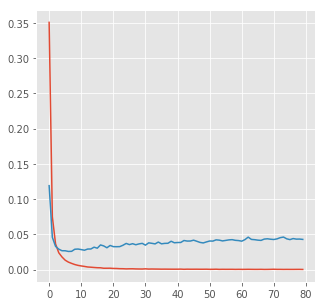

In [19]:
hist = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

#plt.figure(figsize=(5,5))
#plt.plot(hist["acc"])
#plt.plot(hist["val_acc"])
plt.show()

In [20]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])

In [21]:
len(y_pred)

1859

In [22]:
def print_prediction(i):
    p = np.argmax(y_pred[i], axis=-1)
    print("{:15}|{:12}|{}".format("Word", "Dictionary", "Predicted"))
    print(40 * "=")

    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            print("{:15} {:12} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))        

In [23]:
for i in range(0, len(y_pred)):
    print_prediction(i)

Word           |Dictionary  |Predicted
Red             O            O
Dingo           O            O
,               O            O
Capewells       O            O
and             O            O
Iron            B-MINERAL    B-MINERAL
Maiden          O            O
East            O            O
.               O            O
Word           |Dictionary  |Predicted
The             O            O
KKFZ            O            O
is              O            O
interpreted     O            O
to              O            O
define          O            O
the             O            O
western         O            O
margin          O            O
of              O            O
the             O            O
Pig             O            O
Well            O            O
Graben          O            O
,               O            O
which           O            O
consists        O            O
of              O            O
varied          O            O
sedimentary     B-ROCK       B-ROCK
sequence  

In [24]:
len(y_pred) # Number of sentences in prediction / test set

def get_results(i):
    words_value = []
    tags_true = []
    tags_pred = []
    p = np.argmax(y_pred[i], axis=-1)
    #print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    #print(30 * "=")

    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
            words_value.append(idx2word[w])
            tags_true.append(idx2tag[t])
            tags_pred.append(idx2tag[pred])
            
    return words_value, tags_true, tags_pred

In [25]:
#for i in range(0, len(y_pred)):
words_tagged = []
labels_true = []
labels_predicted = []

for i in range(0, len(y_pred)):
    words_value, tags_true, tags_pred = get_results(i)
    words_tagged.extend(words_value)
    labels_true.extend(tags_true)
    labels_predicted.extend(tags_pred)

In [27]:
!pip install seqeval

In [28]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

print(len(labels_true))
#print(y_te[0])

print(len(labels_predicted))
#print(y_pred[0])

#print(classification_report(labels_true, labels_predicted))
print(classification_report(labels_true, labels_predicted, digits=4))

51578
51578
             precision    recall  f1-score   support

    MINERAL     0.9898    0.9777    0.9837       897
       ROCK     0.9716    0.9811    0.9763      1743
   LOCATION     0.9663    0.9609    0.9636      1073
  TIMESCALE     0.9864    0.9864    0.9864       221
ORE_DEPOSIT     0.8871    0.9167    0.9016        60
      STRAT     0.8754    0.9068    0.8908       279

  micro avg     0.9671    0.9698    0.9685      4273
  macro avg     0.9674    0.9698    0.9686      4273



In [ ]:
print(labels_true[:20])
print(labels_predicted[:20])

In [31]:
# Save model2_WL_CL_BiLSTM.h5

from keras.models import load_model

#model.load_weights('CNN_model.weights')
#mCallBack = Callback()
#model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10, callbacks=[mCallBack])
#model.save_weights('CNN_model.weights')

model.save(r"C:/Users/20230326/wamex/data/model_WL_CL_BiLSTM.h5")  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model(r'/Users/majiga/Documents/wamex/datawamex_model.h5')

In [32]:
class WAMEX_Sentence(object): 
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        #agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist())]
        agg_func = lambda s: [w for w in s["Word"].values.tolist()]
        self.grouped = self.data.groupby("SentenceID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [89]:
############### Use this model for labeling all WAMEX files ########################

###### Run the model and tag all rest of the wamex files

#FOLDER_ALL_WAMEX = r"/Users/majiga/Documents/wamex/data/wamex_all/"  # 31,287 files
FOLDER_ALL_WAMEX = r"C:/Users/20230326/wamex/data/wamex_all/"
#FOLDER_ALL_WAMEX_Prediction = r"/Users/majiga/Documents/wamex/data/wamex_all_prediction/"  # 31,287 files
FOLDER_ALL_WAMEX_Prediction = r"C:/Users/20230326/wamex/data/wamex_all_prediction/"  # 31,287 files


wamex_all = glob.glob(os.path.join(FOLDER_ALL_WAMEX, '*.csv'))
print("wamex_all: ", len(wamex_all))

count_files = 0
count_files_error = 0

# 1. read words column
# 2. tag the words using the model
# 3. save back

for filename in wamex_all:
    try:
        # 1.
        #print("File name: " + filename)
        #df = pd.read_csv(filename, usecols=['SentenceID', 'Word', 'POS'])
        data = pd.read_csv(filename, usecols=['SentenceID', 'Word', 'POS'], encoding="latin1")
        # Fill filename cells with the above cell value
        #df["FileName"].fillna(method='ffill', inplace=True)
        #print("data shape: ", df.shape)

        data = data.replace(np.nan, '')
        #words = list(set(data["Word"].values))
        #words.append("ENDPAD")
        #n_words = len(words) # unique words per file
        #print("Number of unique words in this file: ", n_words)
        #data.info()
        #print(data.head(6))

        # 2.
        data["PredictedTag"] = "O"
        #print("data shape: ", data.shape)
        #print(data.head(10))

        #filename_extension = str(filename).split('/')[-1:][0]
        filename_extension = str(filename).split('\\')[-1:][0]
        filename_new = str(filename_extension).split('.')[-2:][0]  + ".txt"
        filename_new = FOLDER_ALL_WAMEX_Prediction + filename_new
        count_files += 1
        #print(count_files, filename_new)
        
        sentences_getter = WAMEX_Sentence(data)
        file_sentences = sentences_getter.sentences
        #print('file_sentences #: ', len(file_sentences))

        new_file = open(filename_new, 'w')

        #X_sentences = [[word2idx[w[0]] for w in s] for s in file_sentences]
        X_sentences = []
        for s in file_sentences:
            #print(s)
            sent = []
            for w in s:
                if w in word2idx.keys():
                    sent.append(word2idx[w])
                else:
                    sent.append(word2idx['UNK'])
            X_sentences.append(sent)
                
        #[[word2idx[w] for w in s] for s in file_sentences]
        
        # Pad the sentences
        X_sentences = pad_sequences(maxlen=max_len, sequences=X_sentences, value=word2idx["PAD"], padding='post', truncating='post')
        #print(file_sentences[0])
        #print(X_sentences[0])

        X_char = []
        for sentence in file_sentences:
            sent_seq = []
            for i in range(max_len):
                word_seq = []
                for j in range(max_len_char):
                    try:
                        word_seq.append(char2idx.get(sentence[i][0][j]))
                    except:
                        word_seq.append(char2idx.get("PAD"))
                sent_seq.append(word_seq)
            X_char.append(np.array(sent_seq))
        #print(X_char[0])
        
        file_p = model.predict([X_sentences,
                                np.array(X_char).reshape((len(X_char), max_len, max_len_char))])

        for i in range(0, len(file_sentences)):
            pr = np.argmax(file_p[i], axis=-1)
            for word, w, pred in zip(file_sentences[i], X_sentences[i], pr):
                #print(w)
                if w != 0:                    
                    #new_file.write(idx2word[w] + ' ' + idx2tag[pred])
                    new_file.write(word + ' ' + idx2tag[pred])
                    new_file.write('\n') # next row
            new_file.write('\n') # next row
            
            
        #p = np.argmax(p, axis=-1)
        #print("{:15}||{}".format("Word", "Prediction"))
        #print(30 * "=")
        #for w, pred in zip(file_sentences, p[0]):
            #print("{:15} {:15}".format(w, tags[pred]))
        #    new_file.write(w + ' ' + tags[pred])
        #    new_file.write('\n') # next row
        #new_file.write('\n') # end of a sentence is empty row   

            #c = c - 1
            #if c == 0: break

        if count_files%100 == 0:
            print(count_files)
            
        new_file.close()
        #print(count_files)
        #break

    except Exception as ex:
        print("Error in file: " + filename + ", error msg: " + str(ex))
        count_files_error += 1
        #break

        
print("Number of successful files: ", count_files)
print("Number of files that had errors: ", count_files_error)

wamex_all:  31287
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
1820

In [29]:
#word2idx.keys()
word2idx.values()

dict_values([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

In [ ]:
X_char = []
sentence = [‘Geographical’]
max_len = 3
max_len_char = 20

for i in range(max_len):
word_seq = []
for j in range(max_len_char):
try:
word_seq.append(char2idx.get(sentence[i][j]))
except:
word_seq.append(char2idx.get(“PAD”))
X_char.append(word_seq)

X_char = [np.array(X_char)]
X_word = [[word2idx[s] if s in word2idx.keys() else word2idx[‘UNK’] for s in sentence]]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx[“PAD”], padding=’post’, truncating=’post’)
X_word = np.array(X_word)
y_pred = model.predict([X_word, np.array(X_char).reshape((len(X_char), max_len, max_len_char))])
p = np.argmax(y_pred[0], axis=-1)

for pred in p:
print(idx2tag[pred])